In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from PIL import Image
import glob
import os

In [3]:
from topaz.utils.data.loader import load_image
import topaz.mrc as mrc

# Topaz-Denoise: micrograph denoising

This tutorial walks through using 'topaz denoise' with the pretrained general denoising models to denoise raw micrographs and also demos how to train a new denoising model on your own data.

__Topaz is assumed to be installed in a conda environment named "topaz" for purposes of running topaz commands within bash cells.__ If topaz was installed in some other way, then the "source activate topaz" lines will need to be removed or changed below.

### Demo dataset

The tutorial dataset can be downloaded [here](http://bergerlab-downloads.csail.mit.edu/topaz/topaz-tutorial-data.tar.gz) and should be unpacked directly in this (the tutorial) directory.

```
wget http://bergerlab-downloads.csail.mit.edu/topaz/topaz-tutorial-data.tar.gz
tar -xzvf topaz-tutorial-data.tar.gz
```


In [4]:
%%bash
# we'll put the denoised micrographs in a directory called data/EMPIAR-10025/denoised
mkdir -p data/EMPIAR-10025/denoised

# Using topaz denoise

Topaz denoise can be used to denoise micrographs using a variety of denoising methods, including pretrained neural network denoising models.

To see the full set of options for topaz denoise, run
```
topaz denoise --help
```

Here, we will cover some of the key options for using topaz denoise with the pretrained denoising models.

### Required argument

{micrographs} <br/>
The list of paths to the micrographs to denoise.

-o\--output {} <br/>
The directory to which denoised micrographs will be saved.

### Optional, but useful, arguments

--suffix {} <br/>
Add this suffix to each output micrograph file path.

--format {} <br/>
What format to save the output micrographs in. Options are mrc, tiff, png, and jpg. Accepts a comma separated list of formats, all of which will be output.

--normalize <br/>
Apply affine normalization (i.e. subtract mean and divide by standard deviation) of each denoised micrograph before saving it.

### Denoising options

-m/--model {} <br/>
Which pretrained denoising model to use. Also accepts the file path of a custom trained denoising model (see below for details on training). Options are unet, unet-small, fcnn, affine, and none. When set to none, no pretrained denoising model is used which is useful for performing only low-pass/Gaussian denoising.

--lowpass {} <br/>
Apply a low-pass filter to the micrographs that bins the micrograph by the specified factor.

--gaussian {} <br/>
Applies a Gaussian filter to the micrographs with standard deviation (in pixels) specified by the argument.

--inv-gaussian {} <br/>
Applies an inverse Gaussian filter to the micrographs with standard deviation (in pixels) specified by the argument.

### Processing efficiency options

-d/--device {} <br/>
Sets which GPU to use. Set to -1 to only use CPU.

-s/--patch-size {} <br/>
Process each micrograph in patches of this size. This is useful when using GPU processing and the micrographs are too large to be denoised in one shot on your GPU.

-p/--patch-padding {} <br/>
Used with patch size, this sets how much additional padding to add to each patch to prevent edge artifacts when stitching them back together.

## Pretrained model details

The pretrained models provided with topaz denoise are:

- unet: the full U-net model (default model)
- unet-small: the small U-net model
- fcnn: the fully convolutional neural network model
- affine: a simple linear denoising model
- unet-v0.2.1: the full U-net model included with topaz version 0.2.1

## Denoising with the pretrained models

In [5]:
%%bash
source activate topaz
# denoise the EMPIAR-10025 micrographs with the full U-net model
# we set the patch size to 2048 to prevent running out of GPU RAM (these micrographs are large)
topaz denoise --patch-size 1024 -o data/EMPIAR-10025/denoised/ data/EMPIAR-10025/rawdata/micrographs/*.mrc

bash: line 1: activate: No such file or directory
# using device=0 with cuda=True
# Loading model: unet
# 30 of 30 completed.


### Visualize an example

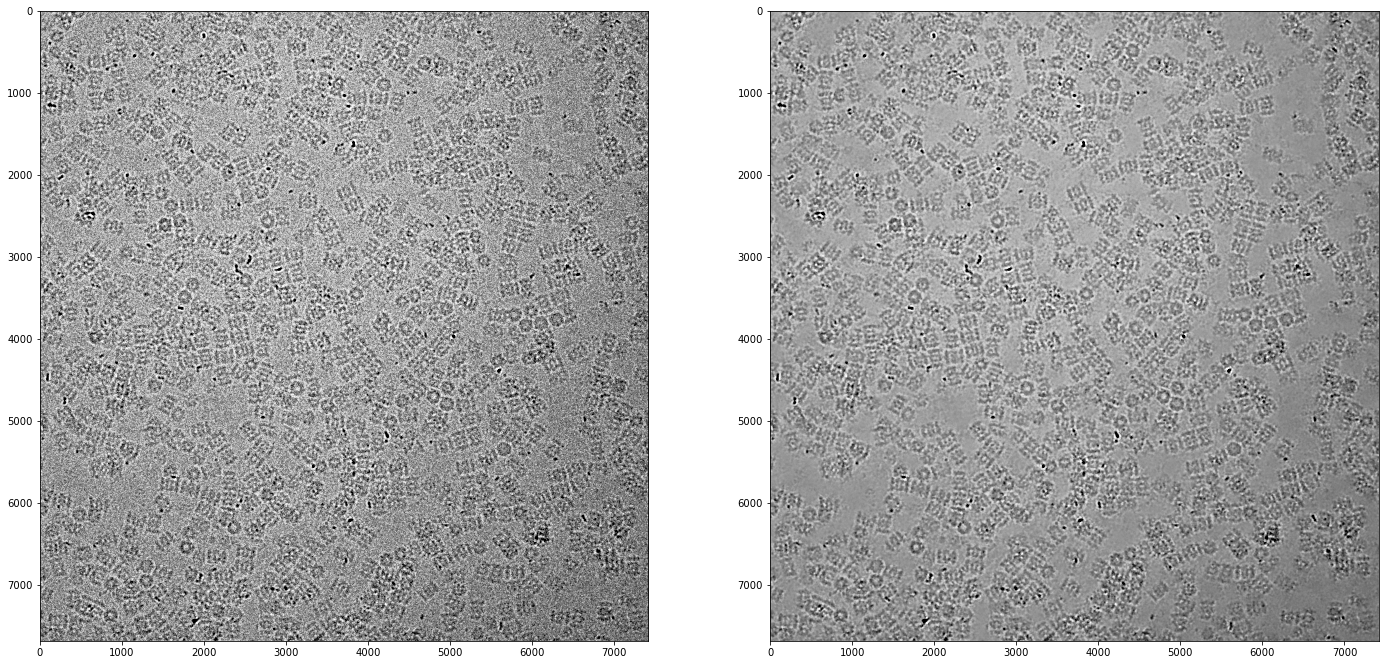

In [6]:
name = '14sep05c_c_00007gr_00013sq_00009hl_00002es_c'

# load the raw micrograph
mic_raw = np.array(load_image('data/EMPIAR-10025/rawdata/micrographs/' + name + '.mrc'), copy=False)
# load the denoised micrograph
mic_dn = np.array(load_image('data/EMPIAR-10025/denoised/' + name + '.mrc'), copy=False)

# scale them for visualization
mu = mic_dn.mean()
std = mic_dn.std()

mic_raw = (mic_raw - mu)/std
mic_dn = (mic_dn - mu)/std

_,ax = plt.subplots(1,2,figsize=(24,12))

ax[0].imshow(mic_raw, vmin=-4, vmax=4, cmap='Greys_r')
ax[1].imshow(mic_dn, vmin=-4, vmax=4, cmap='Greys_r')

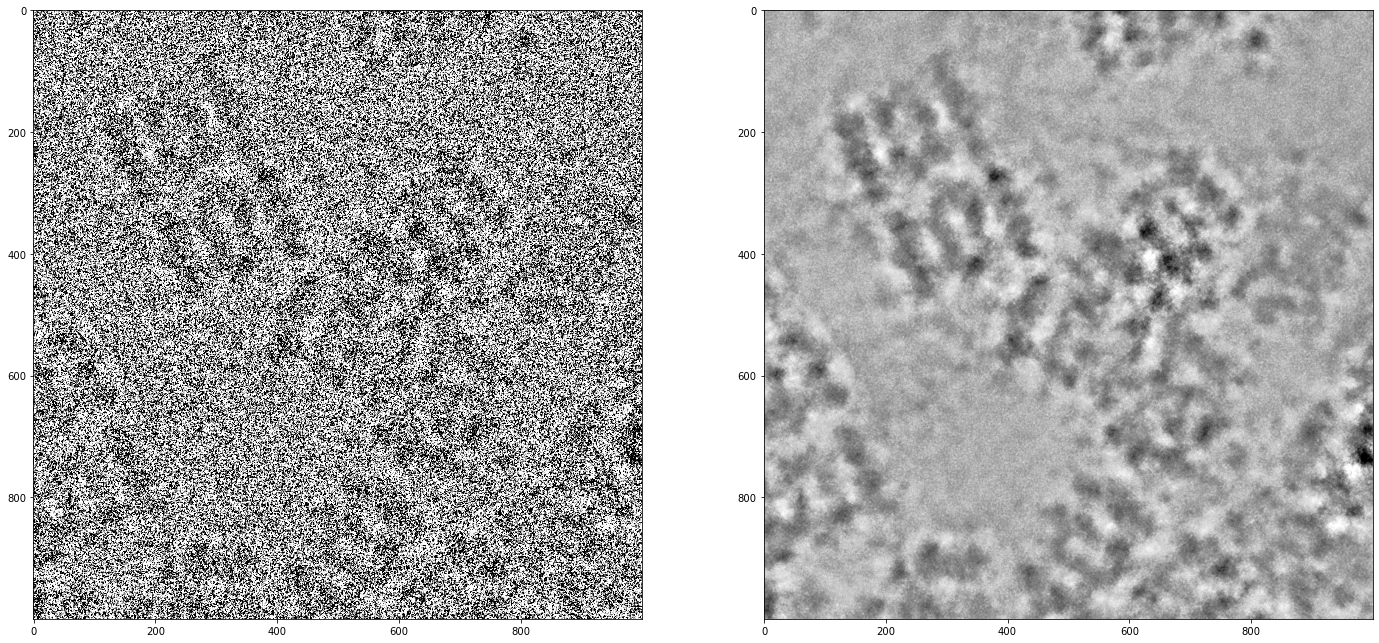

In [7]:
## look at a detail of the micrograph
crop = (2000,3000,3500,4500)

_,ax = plt.subplots(1,2,figsize=(24,12))

ax[0].imshow(mic_raw[crop[0]:crop[1],crop[2]:crop[3]], vmin=-4, vmax=4, cmap='Greys_r')
ax[1].imshow(mic_dn[crop[0]:crop[1],crop[2]:crop[3]], vmin=-4, vmax=4, cmap='Greys_r')

## Denoising model training

For this section off the tutorial, you will need to download an additional dataset containing the full movie frames for several micrographs for training. These can be downloaded [here](http://bergerlab-downloads.csail.mit.edu/topaz/topaz-tutorial-movies.tar.gz) and should be decompressed in the tutorial directory.

```
wget http://bergerlab-downloads.csail.mit.edu/topaz/topaz-tutorial-movies.tar.gz
tar -xzvf topaz-tutorial-movies.tar.gz
```

Warning: this is a large file (~38 GB).

### Preparing the training data

To train new denoising models, topaz denoise requires _paired_, _independent_ samples from the _same underlying signal_, because we use the noise2noise training framework. This means we need paired images of the exact same content. Fortunately, these are easy to get from the raw camera movie frames.

The demo dataset includes 5 movies for this purpose. In order to get paired micrographs from each, we split them in to the even and odd movie frames and then sum these into the even/odd micrographs. In general, we recommend using all micrographs in your dataset, but for simplicity of this demo, we only use 5.

In [8]:
%%bash
mkdir -p data/EMPIAR-10025/denoised/training_data # where we will put the even/odd micrographs for training
mkdir -p data/EMPIAR-10025/denoised/training_data/partA # odd micrographs
mkdir -p data/EMPIAR-10025/denoised/training_data/partB # even micrographs

In [9]:
paths = glob.glob('data/EMPIAR-10025/rawdata/movies/*.mrc') # path to each movie frame

## for each movie frame stack
## split it into even/odd frames, sum them, and store these micrographs
for path in paths:
    name = os.path.basename(path) # just the name of this micrograph
    
    ## load the movie frames
    with open(path, 'rb') as f:
        content = f.read()
    frames,_,_ = mrc.parse(content)
    
    print('Loaded movie frames:', name)
    
    ## split and sum
    odd_mic = frames[::2].sum(0)
    even_mic = frames[1:][::2].sum(0)
    
    ## save the split micrographs
    path = 'data/EMPIAR-10025/denoised/training_data/partA/' + name
    with open(path, 'wb') as f:
        mrc.write(f, odd_mic[np.newaxis])
        
    path = 'data/EMPIAR-10025/denoised/training_data/partB/' + name
    with open(path, 'wb') as f:
        mrc.write(f, even_mic[np.newaxis])
        

Loaded movie frames: 14sep05c_c_00003gr_00014sq_00004hl_00004es_st.mrc
Loaded movie frames: 14sep05c_c_00003gr_00015sq_00015hl_00002es_st.mrc
Loaded movie frames: 14sep05c_c_00003gr_00014sq_00011hl_00003es_st.mrc
Loaded movie frames: 14sep05c_c_00003gr_00014sq_00005hl_00003es_st.mrc
Loaded movie frames: 14sep05c_c_00003gr_00014sq_00007hl_00004es_st.mrc


### Training the denoising model

Now that we have some training data prepared, we can train the model. The new arguments to 'topaz denoise' that are important for model training are:

### Required arguments

-a/--dir-a {} <br/>
The directory containing the odd frame micrographs.

-b/--dir-b {} <br/>
The directory containing the even frame micrographs.

### Optional arguments

--preload <br/>
Load all micrographs into memory before training. Otherwise, topaz denoise will load the micrographs from disk on the fly. Setting this flag can substantially speed up training, but requires enough RAM to hold all of the training data at once.

-c/--crop {} <br/>
Train on subregions of this size randomly sampled from the training micrographs. Defaults to 800.

--arch {} <br/>
What model architecture to use. Set to unet by default.

--criteria {} <br/>
Which training loss to use. Options are L2, L1, and L0. Set to L2 by default.

--num-epochs {} <br/>
How many iterations over the data to train for. Set to 100 by default.

--save-prefix {} <br/>
Where to save the trained models.

In [10]:
%%bash
mkdir -p saved_models/denoising/ # where we'll save the trained models

In [11]:
%%bash
source activate topaz

## train the denoising model
topaz denoise -a data/EMPIAR-10025/denoised/training_data/partA/ \
              -b data/EMPIAR-10025/denoised/training_data/partB/ \
              --save-prefix saved_models/denoising/model \
              --preload

epoch loss_train loss_val
1 1.0022182226181031 0
2 0.9969754457473755 0
3 0.9962797999382019 0
4 0.9955689787864686 0
5 0.9954963326454163 0
6 0.9939482808113098 0
7 0.9953069090843201 0
8 0.9962704300880432 0
9 0.9955034494400025 0
10 0.993400239944458 0
11 0.9951867699623108 0
12 0.9924195408821106 0
13 0.9923986077308655 0
14 0.9941112518310546 0
15 0.9951013088226318 0
16 0.9932859539985657 0
17 0.994079840183258 0
18 0.9939194321632385 0
19 0.9943723201751709 0
20 0.9958999872207641 0
21 0.9926802039146423 0
22 0.9946125507354736 0
23 0.9947887063026428 0
24 0.9916337370872498 0
25 0.9923628330230713 0
26 0.9925233483314514 0
27 0.9956256985664368 0
28 0.9938116192817688 0
29 0.9947159051895141 0
30 0.9954200863838196 0
31 0.9943827986717224 0
32 0.9933397889137268 0
33 0.9961624503135681 0
34 0.9927390575408935 0
35 0.9922042608261108 0
36 0.9944661378860473 0
37 0.9952622771263122 0
38 0.9950207233428955 0
39 0.9934231042861938 0
40 0.9936217546463013 0
41 0.9932187557220459 0
4

# using device=0 with cuda=True
# training with 5 image pairs
# validating on 0 image pairs
                                                                                


## Denoise with our newly trained model and see how things look

In [12]:
%%bash
source activate topaz

topaz denoise -m saved_models/denoising/model_epoch100.sav --patch-size 1024 \
              -o data/EMPIAR-10025/denoised/ data/EMPIAR-10025/rawdata/micrographs/*.mrc

# using device=0 with cuda=True
# Loading model: saved_models/denoising/model_epoch100.sav
# 30 of 30 completed.


### Visualize an example

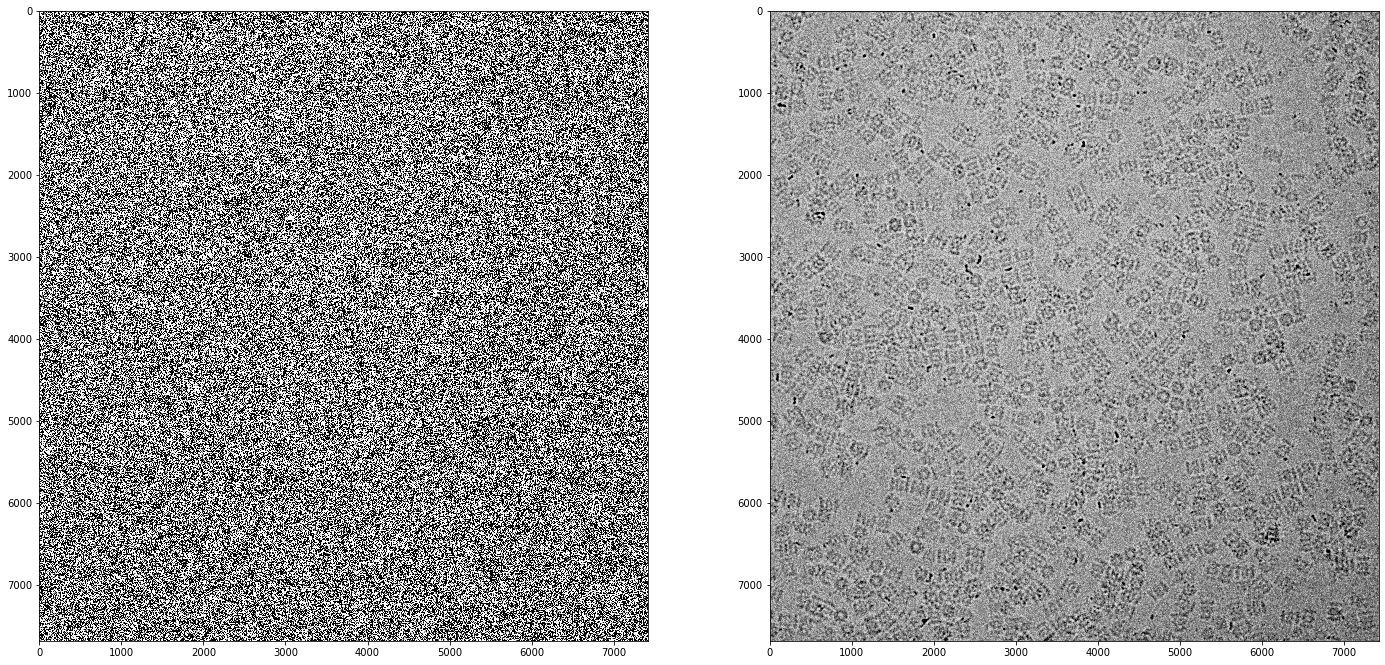

In [13]:
name = '14sep05c_c_00007gr_00013sq_00009hl_00002es_c'

# load the raw micrograph
mic_raw = np.array(load_image('data/EMPIAR-10025/rawdata/micrographs/' + name + '.mrc'), copy=False)
# load the denoised micrograph
mic_dn = np.array(load_image('data/EMPIAR-10025/denoised/' + name + '.mrc'), copy=False)

# scale them for visualization
mu = mic_dn.mean()
std = mic_dn.std()

mic_raw = (mic_raw - mu)/std
mic_dn = (mic_dn - mu)/std

_,ax = plt.subplots(1,2,figsize=(24,12))

ax[0].imshow(mic_raw, vmin=-4, vmax=4, cmap='Greys_r')
ax[1].imshow(mic_dn, vmin=-4, vmax=4, cmap='Greys_r')

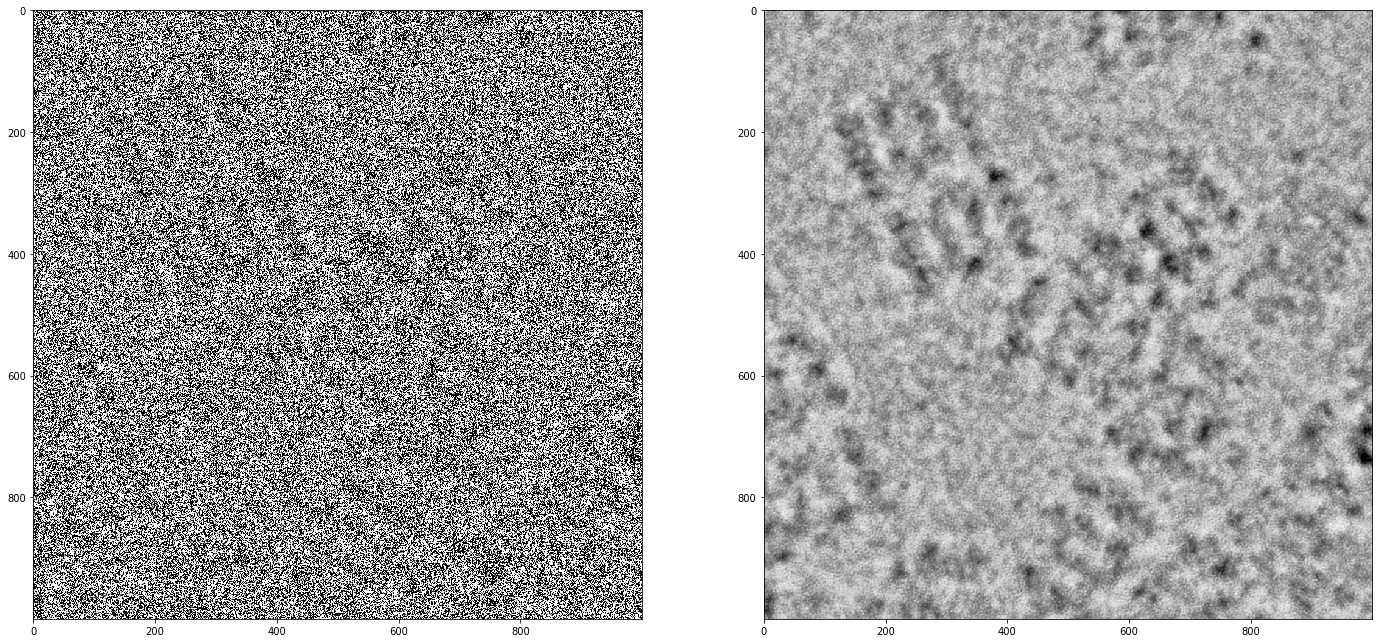

In [14]:
## look at a detail of the micrograph
crop = (2000,3000,3500,4500)

_,ax = plt.subplots(1,2,figsize=(24,12))

ax[0].imshow(mic_raw[crop[0]:crop[1],crop[2]:crop[3]], vmin=-4, vmax=4, cmap='Greys_r')
ax[1].imshow(mic_dn[crop[0]:crop[1],crop[2]:crop[3]], vmin=-4, vmax=4, cmap='Greys_r')